In [241]:
from MyUtils import *

In [242]:
import pandas as pd

In [243]:
"""
- 빈 문자열을 입력으로 locale.setlocale(locale.LC_ALL, '')을 수행하면
  현지 시간/통화에 맞게 locale이 설정됨
- 필요한 이유는, 엑셀에서 읽어온 값을 float(read_data)으로 변환하는
  코드가 있는데, 이 때 1,234와 같이 쉼표를 사용하는 수 표기법을 
  처리하지 못하는 오류가 있어서... 이를 해결하기 위해 아래의 코드를
  실행함
"""
import locale
locale.setlocale(locale.LC_ALL, '')
"""
>> locale.atof('123,456.789')
123456.789
>> locale.atof('123456.789')
123456.789
"""

"\n>> locale.atof('123,456.789')\n123456.789\n>> locale.atof('123456.789')\n123456.789\n"

In [244]:
"""
유효한 시간의 범위
- 예를 들어, 엑셀 파일에는 1/1~5/31까지 있는데, (어떤 이유로) 1월 데이터는
  필요 없을 수 도 있다.
- 여튼, 유효한 시간의 범위를 지정하고, 해당 기간의 데이터에 대해서만
  처리하는 것으로 하자
"""
entireStartDateString = '2016-01-01'
entireStartDateTime = pd.to_datetime(entireStartDateString, format='%Y-%m-%d')

entireEndDateString = '2023-12-31'
entireEndDateTime = pd.to_datetime(entireEndDateString, format='%Y-%m-%d')

In [245]:
# 읽기, 쓰기를 위한 파일의 경로 및 파일명 설정
# - raw data file
year = '2023'

src_dir = '../3.1 필요한 필드만 추출한 엑셀 파일/'
src_filename = '도장B_' + year + '.xlsx'
# - 처리가 완료된 데이터를 저장할 파일
#dst_dir = '../4. 정리된 엑셀 파일/'
dst_dir = '../4.1 일단위로 작업량 계산된 엑셀 파일/'
dst_filename = '2B_선행도장_전체_' + year + '.xlsx'

In [246]:
# raw 파일에서, 작업량 데이터가 저장된 필드 명
srcWorkloadColNames = ['도장-총량']
# raw 파일에서 작업 시작일, 종료일이 문자열로 저장된 열의 이름
srcStartDateStringColName = '도장-착수일자' 
srcEndDateStringColName = '도장-완료일자' 

# 정리된 데이터가 저장될 데이터프레임의 전체 열 이름
# - 단, 첫 열에 "date"는 필수
# - 나머지 열은 raw 파일의 작업량 데이터 필드와 1:1 매칭 되어야 함(이름은 달라도 됨)
dstCompleteColumnNames = ['date', '2B.선행도장>도장']
# 최종 작업량 값이 저장될 필드(열) 이름
dstWorkloadColumnNames = dstCompleteColumnNames[1:]

In [247]:
"""
- 디버깅을 목적으로 추가적인 출력을 만들어낼지 여부를 결정하는 변수이고,
  총 두개 함수에서 사용함 : genEmptyDataFrame, addDailyWorkload
- 특히, addDailyWorkload 는 상당한 양의 출력 구문을 생성해 내기 때문에,
  주피터 노트북을 닫을때 clear output을 하지 않으면 다음에 다시 파일을 열때
  오류가 발생할 수 있다. 따라서 clear output 이후에 파일을 닫는것을 추천한다.
  그렇지 않은 경우, 만약 노트북이 열리지 않으면 VS Code 등으로 파일을 연 다음에
  clear output을 수행하고 다시 주피터 노트북으로 열면 된다.
"""
#DEBUG_PRINT=True
DEBUG_PRINT=False

데이터 불러오기

In [248]:
dfExcel = readExcelFile(src_dir+src_filename, _usecols="B:D")
printDataFrameInfo(dfExcel)

* 데이터 프레임 크기 : 3065 rows, 3 cols
* 필드별 데이터 유형: 
도장-총량       int64
도장-착수일자    object
도장-완료일자    object
dtype: object
* 최초 5개 행 출력: 
   도장-총량     도장-착수일자     도장-완료일자
0      0  2023-01-17  2023-01-19
1      0  2023-01-18  2023-01-20
2      0  2023-01-17  2023-01-19
3      0  2023-01-18  2023-01-20
4      0  2023-03-10  2023-03-13


In [249]:
# 테스트 : 값이 0/null인 셀의 수 확인
print(dfExcel.isnull().sum().sum())

0


In [250]:
# 일 단위로 정리된 데이터를 저장하기 위한 데이터프레임 만들기
dfDailyHistory = genEmptyDataFrame(dtFrom = entireStartDateTime, 
                                   dtTo = entireEndDateTime,
                                   newCols = dstCompleteColumnNames,
                                   DEBUG_PRINT = DEBUG_PRINT)

print(dfDailyHistory.tail(10))

            date  2B.선행도장>도장
1556  2021-12-20           0
1557  2021-12-21           0
1558  2021-12-22           0
1559  2021-12-23           0
1560  2021-12-24           0
1561  2021-12-27           0
1562  2021-12-28           0
1563  2021-12-29           0
1564  2021-12-30           0
1565  2021-12-31           0


In [251]:
processedRows = 0 # 디버깅용 : 오류 없이 처리된 행 수
nRows =len(dfExcel) # raw 파일에서, 전체 데이터 수

#for row in range(TEST_CASE):
for row in range(nRows):
    if DEBUG_PRINT:
        print("Now processing row #%d"%row)

    # 1. raw 데이터 엑셀에서 데이터 획득 (사실은 엑셀을 저장한 데이터프레임에서 획득함)
    # 1.1 작업 시작일 정보 획득 
    startDateString = dfExcel[srcStartDateStringColName][row] # string
    if (type(startDateString) is not str) or (len(startDateString) != 10):
        print("잘못된 착수일자 : ", startDateString, end=' ... ')
        print("(skip 합니다)")
        continue
    dtStartDate = pd.to_datetime(startDateString, format='%Y-%m-%d')
    
    # 1.2. 작업 종료일 정보 획득
    endDateString = dfExcel[srcEndDateStringColName][row] # string
    if (type(endDateString) is not str) or (len(endDateString) != 10):
        print("잘못된 완료일자 : ", endDateString, end=' ... ')
        print("(skip 합니다)")
        continue
    dtEndDate = pd.to_datetime(endDateString, format='%Y-%m-%d')

    # 1.3. 작업 시작/종료일 관련, 오류 처리
    if dtStartDate > dtEndDate:
        print("잘못된 시작/종료 날짜 : From %s to %s (시작/종료 날짜 뒤바꿉니다)"%(startDateString,endDateString))
        startDateString, endDateString = endDateString, startDateString
        dtStartDate, dtEndDate = dtEndDate, dtStartDate
    if dtEndDate < entireStartDateTime:
        print("작업 종료일자가 유효 범위 밖에 있습니다 (skip 합니다)")
        continue
    if dtStartDate > entireEndDateTime:
        print("작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)")
        continue
        
    # 2. 기간내에 근무일 수를 계산 (한국 명절연휴 등은 고려되지 않을 듯...)
    # 전체 작업 기간 중에 유효하지 않은 기간이 포함되어 있더라도(예: 작년말 등)
    # 일단은 전체 작업 기간에 포함해서 1/N을 수행한다.
    # 다만, 최종 데이터프레임에 저장할때는, 유효한 작업기간에 대해서만 저장함
    workingDays = getWorkingDaysFromDateTime(dtStartDate, dtEndDate)
    
    # 3. raw 파일에서 작업량 데이터 읽어오기
    workloadTotal = []
    
    for colName in srcWorkloadColNames:
        try:
            load = float(dfExcel[colName][row])  # 용접장(m) 총량
        except ValueError:
            load = locale.atof(dfExcel[colName][row])
        finally:
            # 예외 발생하든, 그렇지 않든 무조건 실행되는 영역
            # 소수점 두 번째 자리에서 반올림하기
            load = round(load, 2)
        workloadTotal.append(load)
    
    assert len(srcWorkloadColNames) == len(workloadTotal)
    if DEBUG_PRINT:
        print('start: %s, end: %s'%(startDateString, endDateString), end =", ")
        print('for workload: ', workloadTotal, end=", ")
        print('for working day: ', workingDays)

    # 최종 값이 저장될 데이터프레임에서의 필드(열) 이름 : dstWorkloadColumnNames
    assert len(dstWorkloadColumnNames) == len(srcWorkloadColNames)
    
    for workloadItemIndex in range(len(workloadTotal)):
        workload = workloadTotal[workloadItemIndex]
        dstColName = dstWorkloadColumnNames[workloadItemIndex]
        
        if (workload == 0) or (workload is None) or (workload is float('NaN')):
            print("총 작업량 0 (skip 합니다) : ", workload)
            continue    

        if workingDays >= 1:
            # 근무일에 고루 작업이 분배되었을 것으로 가정하고 1/N 으로 계산
            workloadPerDay = workload / workingDays

            # 계산된 작업량을 데이터프레임에 더하기
            addDailyWorkload(dfDailyHistory, dstColName,
                             workloadPerDay,
                             dtStartDate, dtEndDate,
                             entireStartDateTime, entireEndDateTime,
                             DEBUG_PRINT = DEBUG_PRINT)
        else:
            print('[%s] Working day = 0 입니다 (작업량 : %f)'%(startDateString, workload))
            continue
        
    processedRows += 1
    
print("처리된 행 수(working day = 0 포함) : ", processedRows)
print("전체 행 수 : ", len(dfExcel))

작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위 밖에 있습니다 (skip 합니다)
작업 시작일자가 유효 범위

In [252]:
print(dfDailyHistory) # 최종 데이터 테이블을 출력

            date  2B.선행도장>도장
0     2016-01-01           0
1     2016-01-04           0
2     2016-01-05           0
3     2016-01-06           0
4     2016-01-07           0
...          ...         ...
1561  2021-12-27           0
1562  2021-12-28           0
1563  2021-12-29           0
1564  2021-12-30           0
1565  2021-12-31           0

[1566 rows x 2 columns]


In [253]:
# 처리 과정에서 문제가 발생한 행 수를 출력
errorCount = len(dfExcel) - processedRows
print("오류 발생 행 수: ", errorCount)
print("오류 행의 비율: ", errorCount / len(dfExcel))

오류 발생 행 수:  3065
오류 행의 비율:  1.0


파일에 저장하기

In [254]:
if True:
    print("save to : ", dst_dir + dst_filename)
    dfDailyHistory.to_excel(dst_dir + dst_filename)

save to :  ../4.1 일단위로 작업량 계산된 엑셀 파일/2B_선행도장_전체_2023.xlsx


그래프로 시각화하기

<Axes: >

C:\Users\slsl9\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
C:\Users\slsl9\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


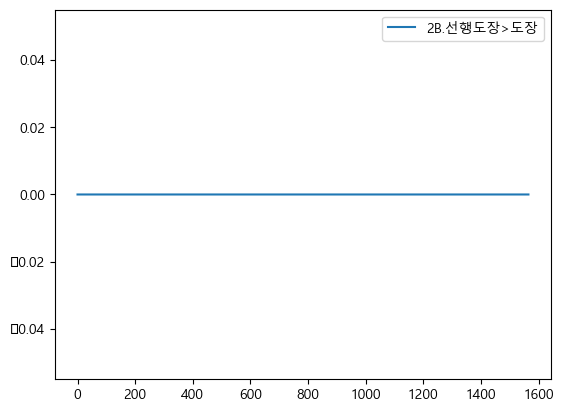

In [255]:
# 한글 폰트 인식
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
dfDailyHistory.plot()

In [256]:
# THE END